In [10]:
import matplotlib.pyplot as plt

# Model Weight Saver

In [29]:
import models

n_runs = 10
hidden_dims = [8, 16, 32, 64, 128]

RNN_models = [[models.RNN(hidden_size=d)]*n_runs for d in hidden_dims]
for dim,model_list in zip(hidden_dims, RNN_models):
    for run, model in enumerate(model_list):
        torch.save(model.state_dict(), f'model_weights\RNN\hidden_dim_{dim}_{run}.pth')

In [ ]:
# from training_loops import RNN_train_aggregated as train

from plane_math import immersion, chart
import models

import torch
torch.set_default_dtype(torch.float64)
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import uniform_direction

import time
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt

n_runs = 10
hidden_dims = [8, 16, 32, 64, 128]
RNN_models = [[models.RNN(hidden_size=d)]*n_runs for d in hidden_dims]

X0, V, pos = torch.load('data\X0.pt').to(device), torch.load('data\V.pt').to(device), torch.load('data\pos.pt').to(device)

N = X0.shape[0]
n = V.shape[1]
# Data Preparation and Train-Test Splitting
train_test_split = 0.8
X0_train = X0[:int(train_test_split*N)]
X0_test = X0[int(train_test_split*N):]
V_train = V[:int(train_test_split*N)]
V_test = V[int(train_test_split*N):]
pos_train = pos[:int(train_test_split*N)]
pos_test = pos[int(train_test_split*N):]

batch_size = 1024
num_epochs = 1000

def train(net, X0, V, pos, seq_length, indices_to_aggregate=[], lr=0.01, batch_size = 1024, num_epochs = 1000):
  k = seq_length
  # Define optimizer and scheduler
  optimizer = optim.Adam(net.parameters(), lr = lr)  # Example optimizer
  # Load your dataset
  train_loader = DataLoader(TensorDataset(X0, V, pos), batch_size=batch_size, shuffle=True)

  # Training loop
  num_epochs = num_epochs
  run_time = time.time()
  if len(indices_to_aggregate)>0:
    L = indices_to_aggregate
  else:
    L = range(1, k+1)
  # print(f"Training by aggregating on indices {L}")
  for epoch in (range(num_epochs)):
      running_loss = 0.0

      for minibatch in train_loader:

          # Forward pass
          X = minibatch[0].to(device)
          V = minibatch[1].to(device)
          Y = minibatch[2].to(device)
          loss = 0

          for i in L:
            Yhat = net(X,V[:,:i]).squeeze()
            criterion = nn.MSELoss()
            loss += criterion(immersion(Y[:,i-1]), immersion(Yhat))


          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      # if epoch%100==0:
      #   print(f"Epoch = {epoch+1}, Loss = {running_loss/len(train_loader) :.4e}")
  runtime = time.time()-run_time  
  # print(f"Training time = {runtime}")
  return runtime


# Training all models and computing predictions
runtimes = []
for dim, model_list in tqdm(zip(hidden_dims, RNN_models)):
    times = []
    for run, model in enumerate(model_list):
        t = train(model, X0=X0_train, V=V_train, pos=pos_train, seq_length=10, indices_to_aggregate=[], lr=0.01, batch_size = batch_size, num_epochs = num_epochs)
        times.append(t)
        torch.save(model.state_dict(), f'model_weights\RNN\hidden_dim_{dim}_{run}.pth')
        pos_pred = torch.zeros_like(pos_test)
        for i in range(n):
            pos_pred[:,i] = model(x_0=X0_test, V=V_test[:,:i+1]).squeeze()
        torch.save(pos_pred, f'results\RNN\hidden_dim_{dim}_{run}.pt')



C:\Users\Sathya\AppData\Local\Temp\ipykernel_32552\564096028.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X0, V, pos = torch.load('data\X0.pt')[:100].to(device), tor

In [7]:
pos1 = torch.load('results\RNN\hidden_dim_8_0.pt')
pos1.shape

C:\Users\Sathya\AppData\Local\Temp\ipykernel_32552\3024377540.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pos1 = torch.load('results\RNN\hidden_dim_8_0.pt')


torch.Size([20, 100, 2])

In [2]:
def train(net, X0, V, pos, seq_length, indices_to_aggregate=[], lr=0.01, batch_size = 1024, num_epochs = 1000):
  k = seq_length


  # Define optimizer and scheduler
  optimizer = optim.Adam(net.parameters(), lr = lr)  # Example optimizer


  # Load your dataset
  train_loader = DataLoader(TensorDataset(X0, V, pos), batch_size=batch_size, shuffle=True)

  # Training loop
  num_epochs = num_epochs
  run_time = time.time()
  if len(indices_to_aggregate)>0:
    L = indices_to_aggregate
  else:
    L = range(1, k+1)
  # print(f"Training by aggregating on indices {L}")
  for epoch in (range(num_epochs)):
      running_loss = 0.0

      for minibatch in train_loader:

          # Forward pass
          X = minibatch[0].to(device)
          V = minibatch[1].to(device)
          Y = minibatch[2].to(device)
          loss = 0

          for i in L:
            Yhat = net(X,V[:,:i]).squeeze()
            criterion = nn.MSELoss()
            loss += criterion(immersion(Y[:,i-1]), immersion(Yhat))


          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      # if epoch%100==0:
      #   print(f"Epoch = {epoch+1}, Loss = {running_loss/len(train_loader) :.4e}")
  runtime = time.time()-run_time  
  # print(f"Training time = {runtime}")
  return runtime

In [ ]:
import torch
import random_generators #local


n = 100 # Sequence Length
N = 50000 # Batch Size
max_v = 0.1 # Scale parameter for velocities



# Initial Pts
a = 1 # Initial disk radius
X0 = random_generators.generate_uniform_disk_vectors_torch(num_vectors=N, epsilon=a)

# Velocities
epsilon = 0.1
V = torch.zeros((N, n, 2))
for i in range(n):
    V[:,i] = random_generators.generate_uniform_disk_vectors_torch(num_vectors=N, epsilon=epsilon)


pos_rel = torch.cumsum(V, dim=1)
pos = X0.unsqueeze(1) + pos_rel # Ground Truth Positions

path = 'data\plane'
torch.save(pos, f'{path}\pos.pt')
torch.save(V, f'{path}\V.pt')
torch.save(X0, f'{path}\X0.pt')

tensor(2.9003, dtype=torch.float64)

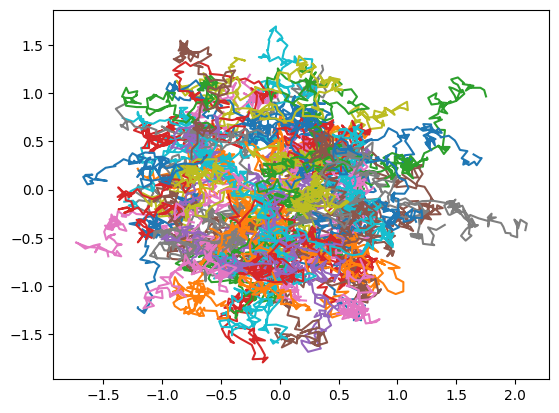

In [19]:
for i in range(100):
    plt.plot(pos[i,:,0],pos[i,:,1])

pos.norm(dim=2).max()

In [44]:
X0.dtype

torch.float64

(array([[ 112.,  331.,  499.,  678.,  867., 1141., 1270., 1496., 1734.,
         1872.],
        [  98.,  285.,  530.,  660.,  939., 1129., 1264., 1470., 1713.,
         1912.],
        [  89.,  306.,  538.,  742.,  912., 1098., 1296., 1527., 1647.,
         1845.],
        [ 103.,  320.,  510.,  680.,  913., 1111., 1350., 1508., 1698.,
         1807.],
        [  98.,  338.,  510.,  684.,  894., 1080., 1283., 1555., 1689.,
         1869.],
        [ 103.,  349.,  483.,  737.,  908., 1066., 1293., 1568., 1613.,
         1880.],
        [ 102.,  283.,  513.,  668.,  925., 1050., 1302., 1465., 1753.,
         1939.],
        [ 111.,  326.,  483.,  728.,  873., 1083., 1293., 1428., 1750.,
         1925.],
        [  97.,  288.,  508.,  667.,  926., 1138., 1276., 1524., 1716.,
         1860.],
        [  99.,  281.,  489.,  724.,  894., 1084., 1319., 1508., 1697.,
         1905.],
        [  97.,  282.,  465.,  693.,  938., 1093., 1256., 1516., 1741.,
         1919.],
        [ 104.,  302.

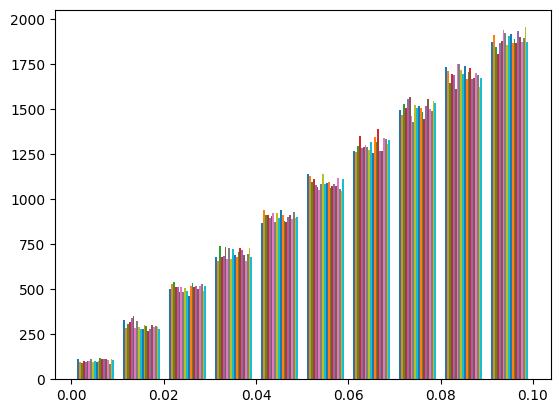